# Green Team Neural Network

In [7]:
import tensorflow as tf
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore")
import glob
import matplotlib.pyplot as plt

### Defining functions for setting up and plotting data

In [8]:
def read_label():
    label = {}
    for i in range(1, 7):
        hi = 'low_freq/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(hi) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label
labels = read_label()
for i in range(1,3):
    print('House {}: '.format(i), labels[i], '\n')


def read_merge_data(house):
    path = 'low_freq/house_{}/'.format(house)
    file = path + 'channel_1.dat'
    df = pd.read_table(file, sep=' ', names=['unix_time', labels[house][1]],
                       dtype={'unix_time': 'int64', labels[house][1]: 'float64'})

    num_apps = len(glob.glob(path + 'channel*'))
    for i in range(2, num_apps + 1):
        file = path + 'channel_{}.dat'.format(i)
        data = pd.read_table(file, sep=' ', names=['unix_time', labels[house][i]],
                             dtype={'unix_time': 'int64', labels[house][i]: 'float64'})
        df = pd.merge(df, data, how='inner', on='unix_time')
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time', 'timestamp'], axis=1, inplace=True)
    return df

def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.loc[dates[i]].index[look_back:]
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = len(ind)
    plt.show()
    
def mse_loss(y_predict, y):

    return np.mean(np.square(y_predict - y))


def mae_loss(y_predict, y):

    return np.mean(np.abs(y_predict - y))


def build_fc_model():

    fc_model = Sequential()
    fc_model.add(tf.keras.layers.Dense(2, activation='relu'))
    fc_model.add(tf.keras.layers.Dense(256, activation='relu'))
    fc_model.add(tf.keras.layers.Dense(512))
    fc_model.add(tf.keras.layers.Dense(1024))
    fc_model.add(tf.keras.layers.Dense(1))
    fc_model.build((214816, 2))
    fc_model.summary()

    return fc_model

House 1:  {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'} 

House 2:  {1: 'mains_1', 2: 'mains_2', 3: 'kitchen_outlets_3', 4: 'lighting_4', 5: 'stove_5', 6: 'microwave_6', 7: 'washer_dryer_7', 8: 'kitchen_outlets_8', 9: 'refrigerator_9', 10: 'dishwaser_10', 11: 'disposal_11'} 



### Generating test, train, and validation sets

In [14]:
df = {}
for i in range(1, 3):
    df[i] = read_merge_data(i)

dates = {}
for i in range(1,3):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

df1_train = df[1].loc[:dates[1][10]]
df1_val = df[1].loc[dates[1][11]:dates[1][16]]
df1_test = df[1].loc[dates[1][17]:]
print('df_train.shape: ', df1_train.shape)
print('df_val.shape: ', df1_val.shape)
print('df_test.shape: ', df1_test.shape)

X_train1 = df1_train[['mains_1','mains_2']].values
y_train1 = df1_train['lighting_9'].values
X_val1 = df1_val[['mains_1','mains_2']].values
y_val1 = df1_val['lighting_9'].values
X_test1 = df1_test[['mains_1','mains_2']].values
y_test1 = df1_test['lighting_9'].values
print(X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)

House 1 data contain 23 days from 2011-04-18 to 2011-05-24.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24'] 

House 2 data contain 16 days from 2011-04-18 to 2011-05-22.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22'] 

df_train.shape:  (214816, 20)
df_val.shape:  (104875, 20)
df_test.shape:  (87057, 20)
(214816, 2) (214816,) (104875, 2) (104875,) (87057, 2) (87057,)


### Creating model

In [15]:
fc_model_1 = build_fc_model()

adam = Adam(lr = 1e-5)
fc_model_1.compile(loss='mean_squared_error', optimizer=adam)
start = time.time()
checkpointer = ModelCheckpoint(filepath="./fc_light_h1_2.hdf5", verbose=0, save_best_only=True)
hist_fc_1 = fc_model_1.fit( X_train1, y_train1,
                    batch_size=512, verbose=1, epochs=5,
                    validation_split=0.33, callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (214816, 2)               6         
_________________________________________________________________
dense_6 (Dense)              (214816, 256)             768       
_________________________________________________________________
dense_7 (Dense)              (214816, 512)             131584    
_________________________________________________________________
dense_8 (Dense)              (214816, 1024)            525312    
_________________________________________________________________
dense_9 (Dense)              (214816, 1)               1025      
Total params: 658,695
Trainable params: 658,695
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
282/282 [==============================] - 6s 22ms/step - loss: 3643.0642 - val_loss: 3589.6672
Epoch 2/

### Calculating Mse and Mae

In [16]:
fc_model_1 = load_model('fc_light_h1_2.hdf5')
pred_fc_1 = fc_model_1.predict(X_test1).reshape(-1)
mse_loss_fc_1 = mse_loss(pred_fc_1, y_test1)
mae_loss_fc_1 = mae_loss(pred_fc_1, y_test1)
print('Mean square error on test set: ', mse_loss_fc_1)
print('Mean absolute error on the test set: ', mae_loss_fc_1)

train_loss = hist_fc_1.history['loss']
val_loss = hist_fc_1.history['val_loss']

Mean square error on test set:  1973.4452004904429
Mean absolute error on the test set:  26.672474688642986


### Plotting final result

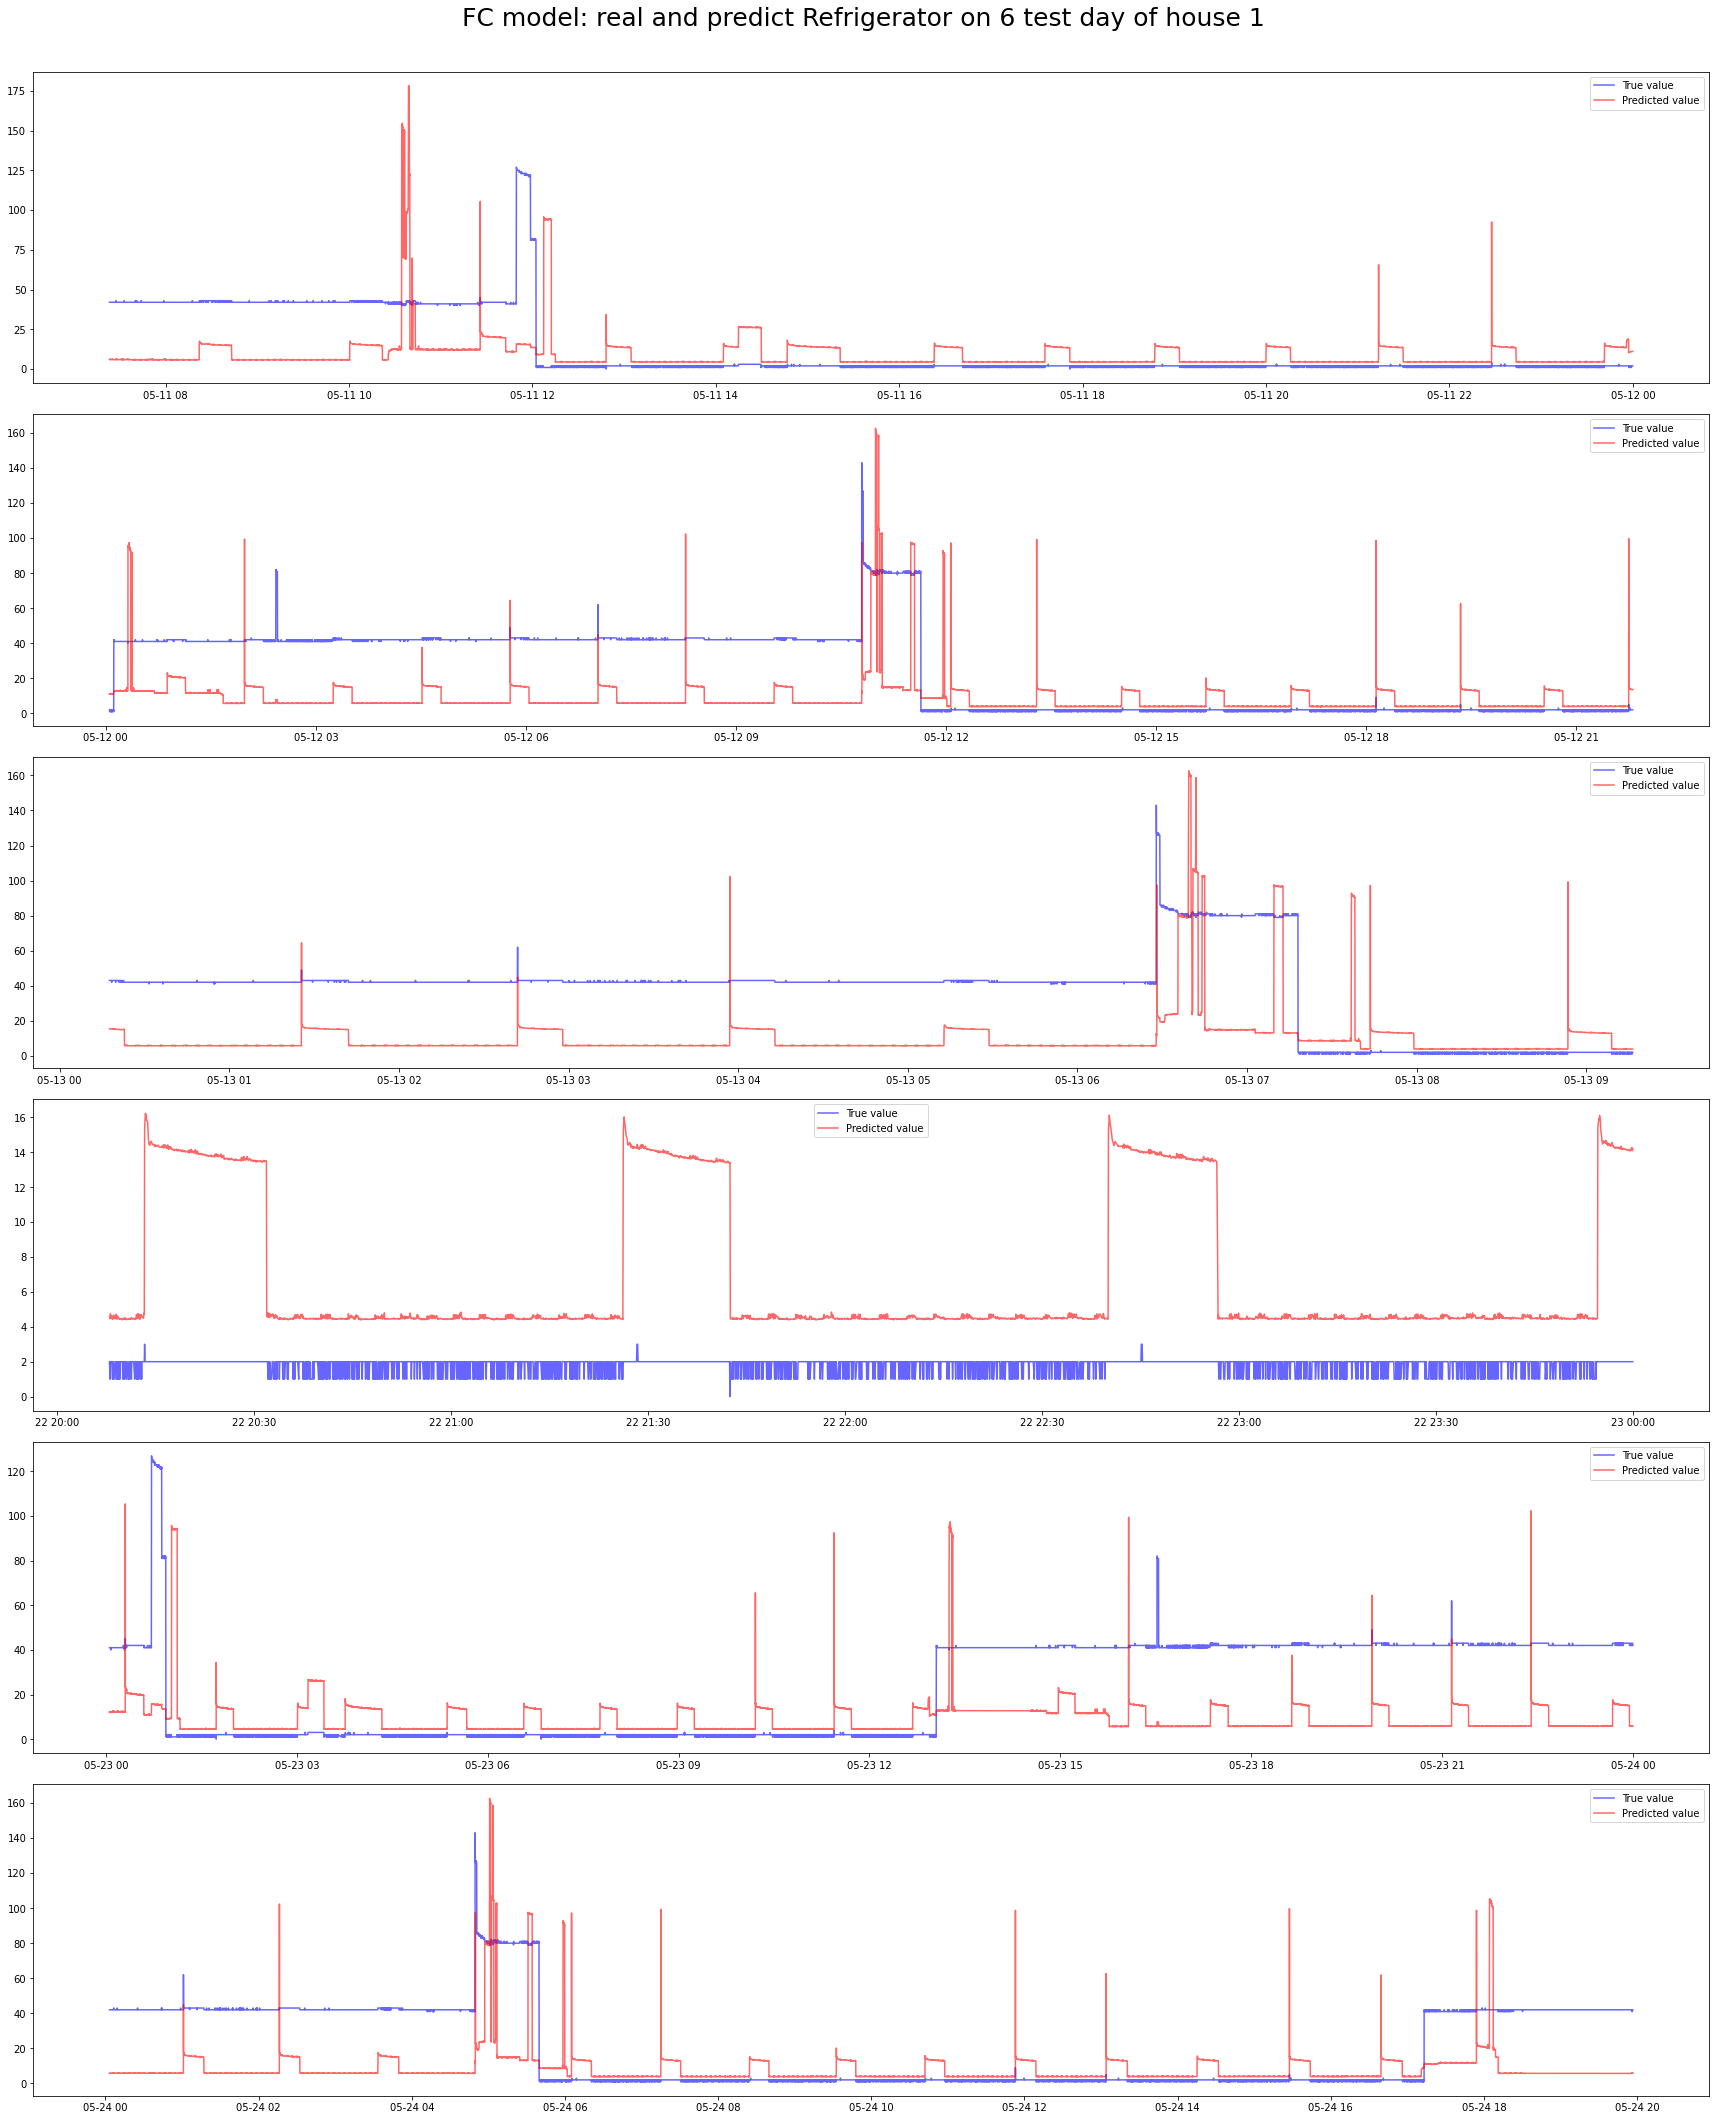

In [17]:
plot_each_app(df1_test, dates[1][17:], pred_fc_1, y_test1,
              'FC model: real and predict Refrigerator on 6 test day of house 1', look_back = 50)